In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn import model_selection
from sklearn import metrics
from imblearn.over_sampling import BorderlineSMOTE as Balance
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC 
from xgboost import XGBClassifier as XGB

In [2]:
Dataset = pd.read_csv('Bank 2011 - Clean.csv', sep=',')

In [3]:
X, Y = Dataset.drop(columns='Y', axis=1), Dataset['Y']

In [4]:
def Label_Visualization(Title_Label):    
    Fig, (Ax1, Ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
    Fig.suptitle(Title_Label, backgroundcolor='yellow', fontsize=16.5)

    Label_Counts = Y.value_counts()

    Label_Counts.plot(kind='bar', ax=Ax1)
    Ax1.set_title('Biểu đồ số lượng nhãn')
    Ax1.set_xlabel('Nhãn')
    Ax1.set_ylabel('Số lượng')
    Ax1.set_xticklabels(Ax1.get_xticklabels(), rotation=0)
    for Each in Ax1.patches:
        Number_Class = f"{Each.get_height()}"
        x, y = (Each.get_x() + Each.get_width()/2, Each.get_height())
        Ax1.annotate(Number_Class, (x, y), ha='center', va='bottom')
        
    Label_Counts.plot(kind='pie', autopct='%1.2f%%', ax=Ax2)
    Ax2.set_title('Biểu đồ tỷ trọng nhãn')
    Ax2.set_ylabel(None)
    Ax2.legend(labels=Label_Counts.index).set_title('Nhãn')
    
    plt.show()

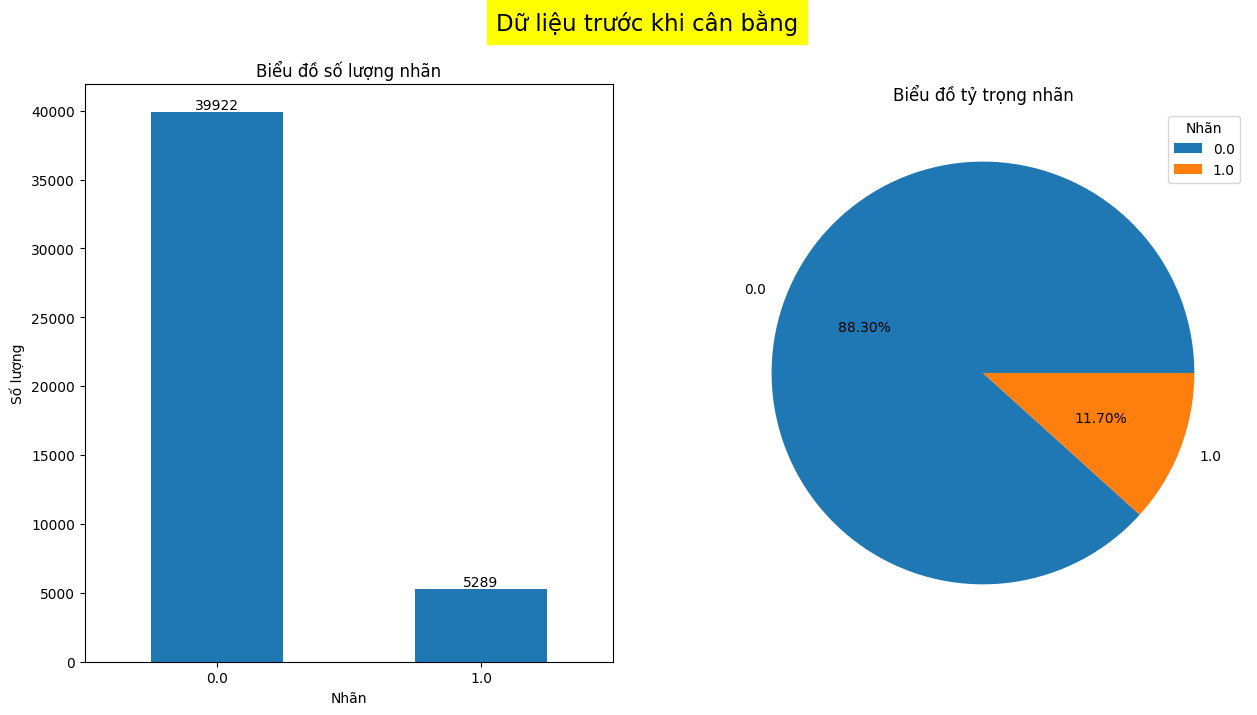

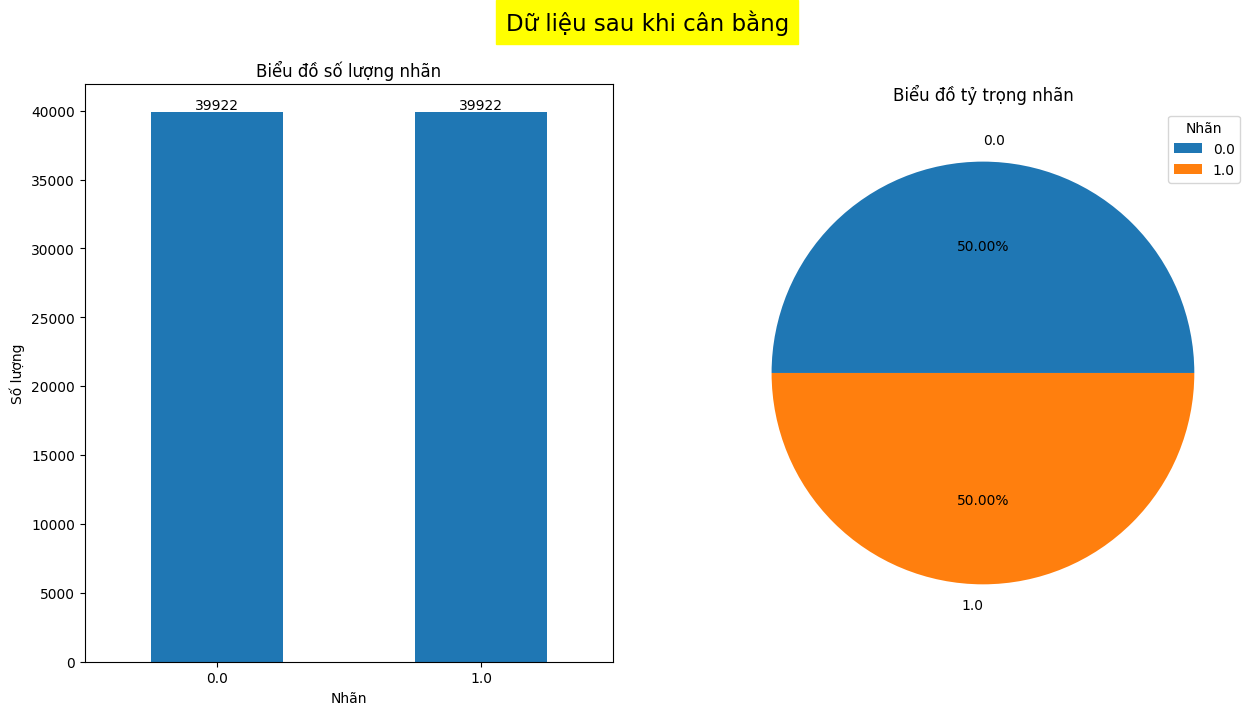

In [5]:
Label_Visualization('Dữ liệu trước khi cân bằng')
X, Y = Balance(random_state=42).fit_resample(X, Y)
Label_Visualization('Dữ liệu sau khi cân bằng')

In [6]:
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)

Param_DTC = { 
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth': [15, 16, 17],
    'min_samples_split': [2, 3, 4, 5],
}

Param_RFC = {
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth': [22, 23, 24],
    'min_samples_split': [2, 3, 4, 5],
}

Param_XGB = {
    'learning_rate':[0.1, 0.2, 0.3],
    'max_depth':[2, 4, 6, 8, 10],
    'gamma':[0, 0.25, 0.5, 0.75],
    'subsample': [0.4, 0.6, 0.8],
}

Init_Models = {
    'DTC': (DTC(), Param_DTC),
    'RFC': (RFC(), Param_RFC),
    'XGB': (XGB(), Param_XGB),
}

Best_Models = {
    # Lưu các mô hình tốt nhất
}

for Name, (Model, Param) in Init_Models.items():
    Search = model_selection.GridSearchCV(Model, Param, cv=10, n_jobs=4)
    Search.fit(X_Train, Y_Train)
    Best_Model, Best_Param = Search.best_estimator_, Search.best_params_
    Best_Models[Name] = Best_Model
    print(f"Tham số tối ưu {Name}: {Best_Param}")
    Score = Best_Model.score(X_Test, Y_Test)
    print(f"Điểm đánh giá mô hình: {Score*100}%")

Tham số tối ưu DTC: {'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 2}
Điểm đánh giá mô hình: 90.9576688653252%
Tham số tối ưu RFC: {'max_depth': 23, 'min_samples_leaf': 2, 'min_samples_split': 3}
Điểm đánh giá mô hình: 93.38315103949236%
Tham số tối ưu XGB: {'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 10, 'subsample': 0.8}
Điểm đánh giá mô hình: 93.48751774233949%


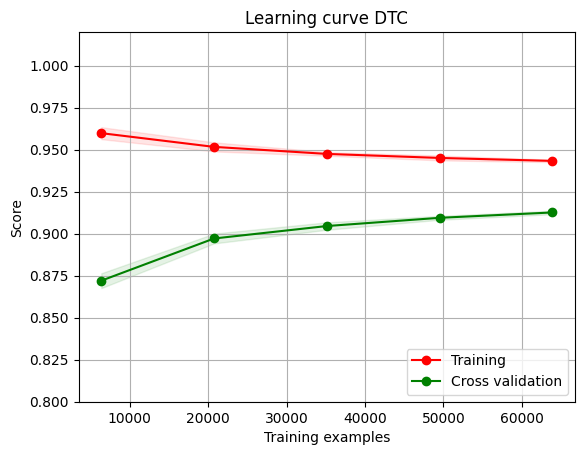

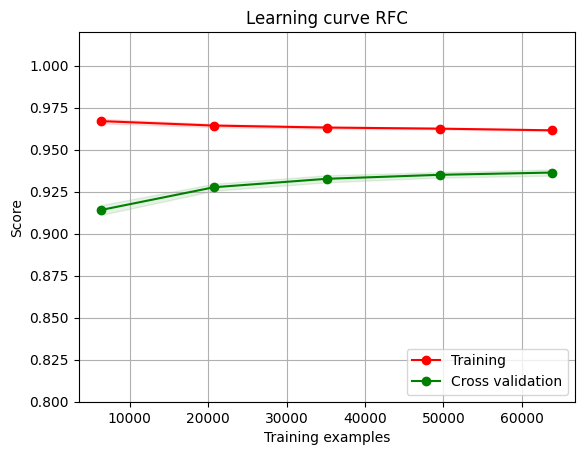

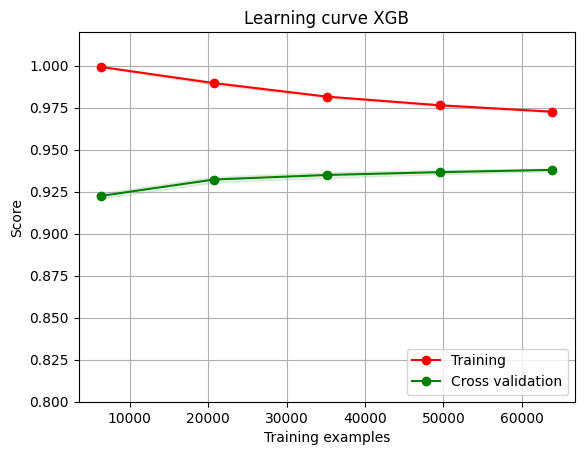

In [15]:
for Name, Model in Best_Models.items():
    Train_Sizes, Train_Scores, Test_Scores = model_selection.learning_curve(
    Model, X, Y, cv=model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
    )
    Train_Scores_Mean = np.mean(Train_Scores, axis=1)
    Train_Scores_Std = np.std(Train_Scores, axis=1)
    Test_Scores_Mean = np.mean(Test_Scores, axis=1)
    Test_Scores_Std = np.std(Test_Scores, axis=1)
    plt.fill_between(Train_Sizes,
                    Train_Scores_Mean - Train_Scores_Std,
                    Train_Scores_Mean + Train_Scores_Std,
                    alpha=0.1, color="r")
    plt.fill_between(Train_Sizes,
                    Test_Scores_Mean - Test_Scores_Std,
                    Test_Scores_Mean + Test_Scores_Std,
                    alpha=0.1, color="g")
    plt.plot(Train_Sizes, Train_Scores_Mean, 'o-', 
             color="r", label="Training")
    plt.plot(Train_Sizes, Test_Scores_Mean, 'o-',
            color="g", label="Cross validation")
    plt.title(f"Learning curve {Name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.8, 1.02)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [8]:
KF = model_selection.KFold(n_splits=10, shuffle=True)
Results = []
for Train_Index, Test_Index in KF.split(X):
    X_Train, X_Test = X.iloc[Train_Index], X.iloc[Test_Index]
    Y_Train, Y_Test = Y.iloc[Train_Index], Y.iloc[Test_Index]
    for Name, Model in Best_Models.items():
        Model.fit(X_Train, Y_Train)
        Y_Pred = Model.predict(X_Test)
        Acc = metrics.accuracy_score(Y_Test, Y_Pred)
        F1c = metrics.f1_score(Y_Test, Y_Pred)
        Pre = metrics.precision_score(Y_Test, Y_Pred)
        Rec = metrics.recall_score(Y_Test, Y_Pred)
        Results.append([Name, Acc*100, Pre*100, Rec*100, F1c*100])

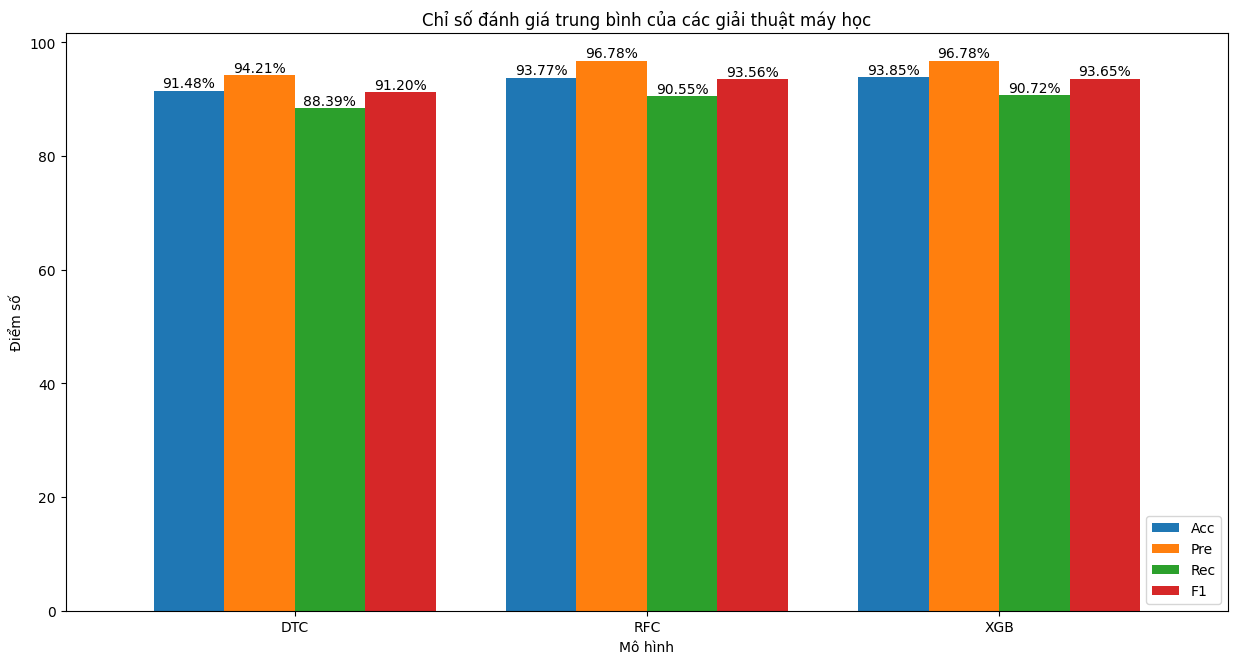

In [9]:
Col = ['Model', 'Acc', 'Pre', 'Rec', 'F1']
Report = pd.DataFrame(Results, columns=Col)
Average = Report.groupby('Model').mean()
Chart = Average.plot(kind='bar', figsize=(15, 7.5), width=0.8)
for Each in Chart.patches:
    Percentage = f"{Each.get_height():.2f}%"
    x, y = (Each.get_x() + Each.get_width()/2, Each.get_height())
    Chart.annotate(Percentage, (x, y), ha='center', va='bottom')
plt.title('Chỉ số đánh giá trung bình của các giải thuật máy học')
plt.xlabel('Mô hình')
plt.ylabel('Điểm số')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

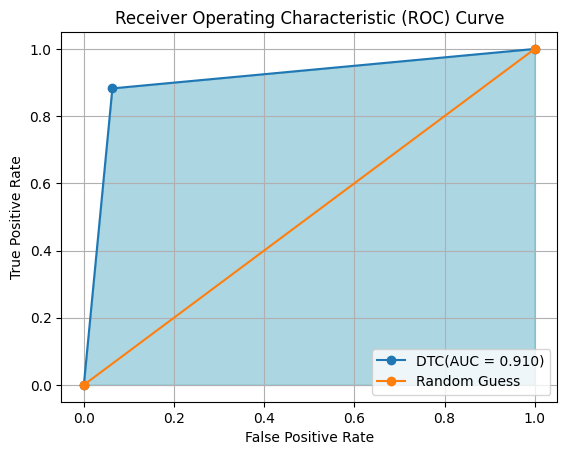

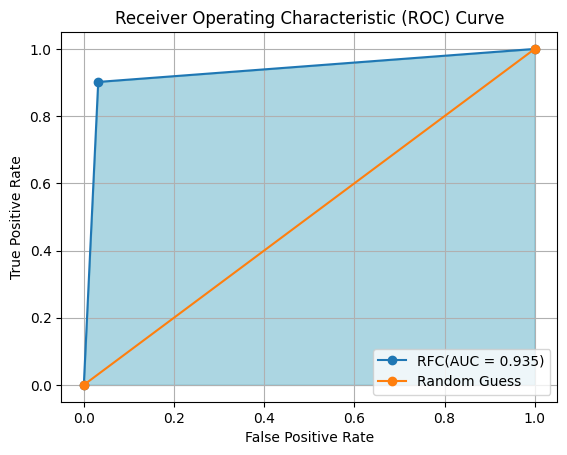

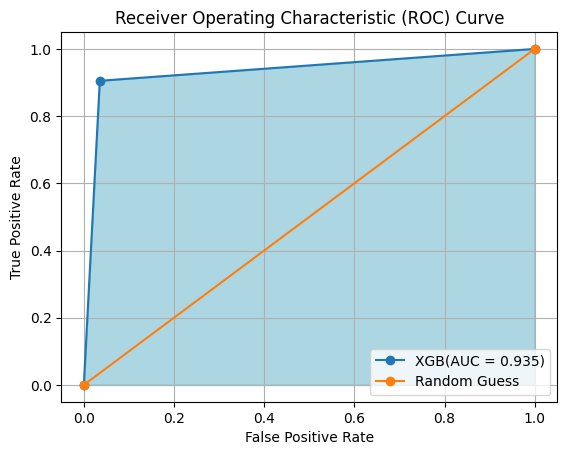

In [10]:
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
List_Model = {}
for Name, Model in Best_Models.items():
    Model.fit(X_Train, Y_Train)
    Y_Pred = Model.predict(X_Test)
    Fpr, Tpr, Thresholds = metrics.roc_curve(Y_Test, Y_Pred)
    List_Model[Name] = (Fpr, Tpr)
for Name, (Fpr, Tpr) in List_Model.items():
    plt.plot(Fpr, Tpr, label='%s(AUC = %0.3f)'%(Name, metrics.auc(Fpr, Tpr)), marker='o', linewidth=1.5)
    plt.plot([0, 1], [0, 1], label='Random Guess', marker='o')
    plt.fill_between(Fpr, Tpr, color='#0081A7', alpha=0.325)
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

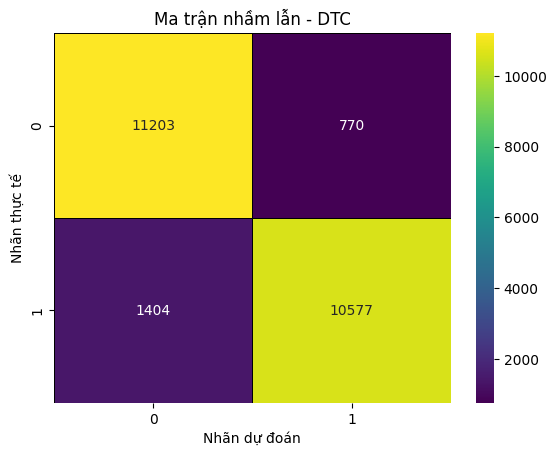

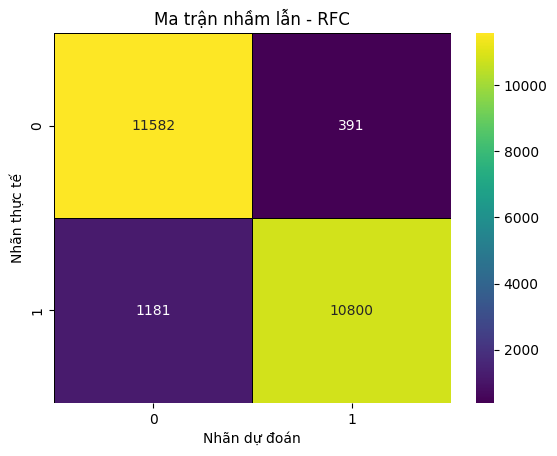

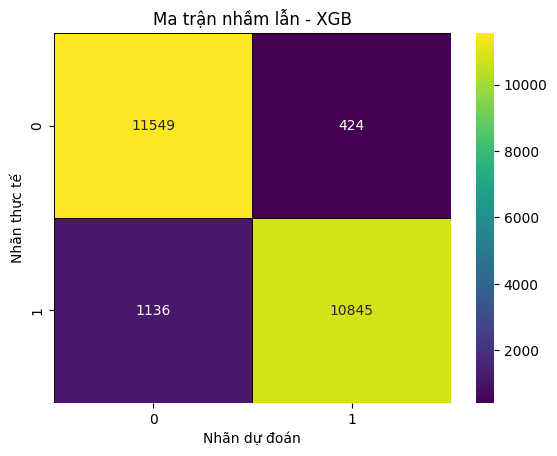

In [11]:
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
for Name, Model in Best_Models.items():
    Model.fit(X_Train, Y_Train)
    Y_Pred = Model.predict(X_Test)
    Confusion_Matrix = metrics.confusion_matrix(Y_Test, Y_Pred)
    sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap="viridis", linewidths=0.5, linecolor='black')
    plt.xlabel('Nhãn dự đoán')
    plt.ylabel('Nhãn thực tế')
    plt.title(f'Ma trận nhầm lẫn - {Name}')
    plt.show()

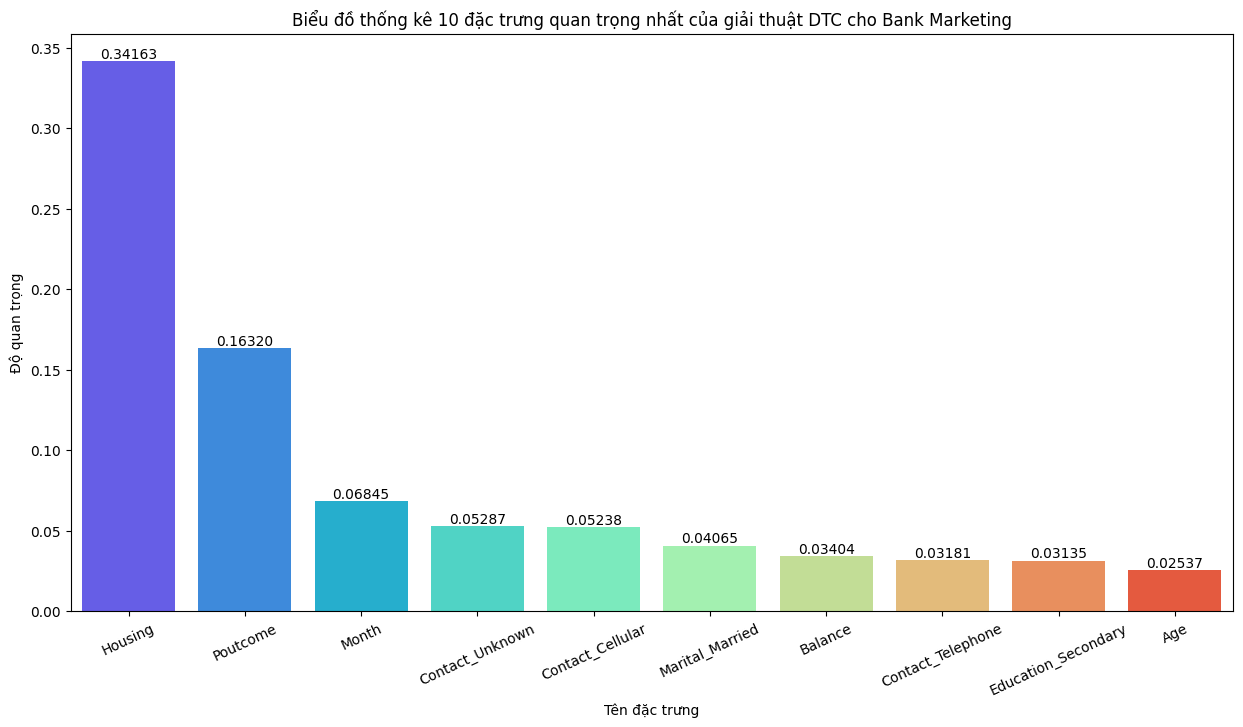

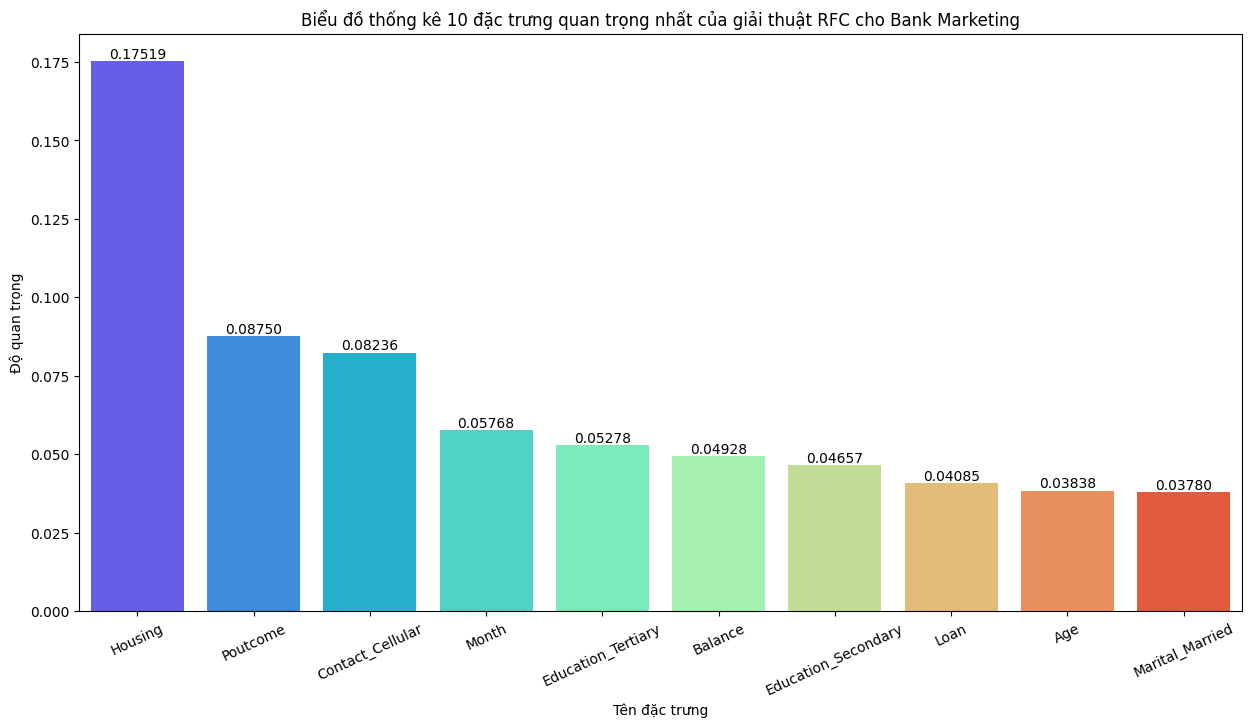

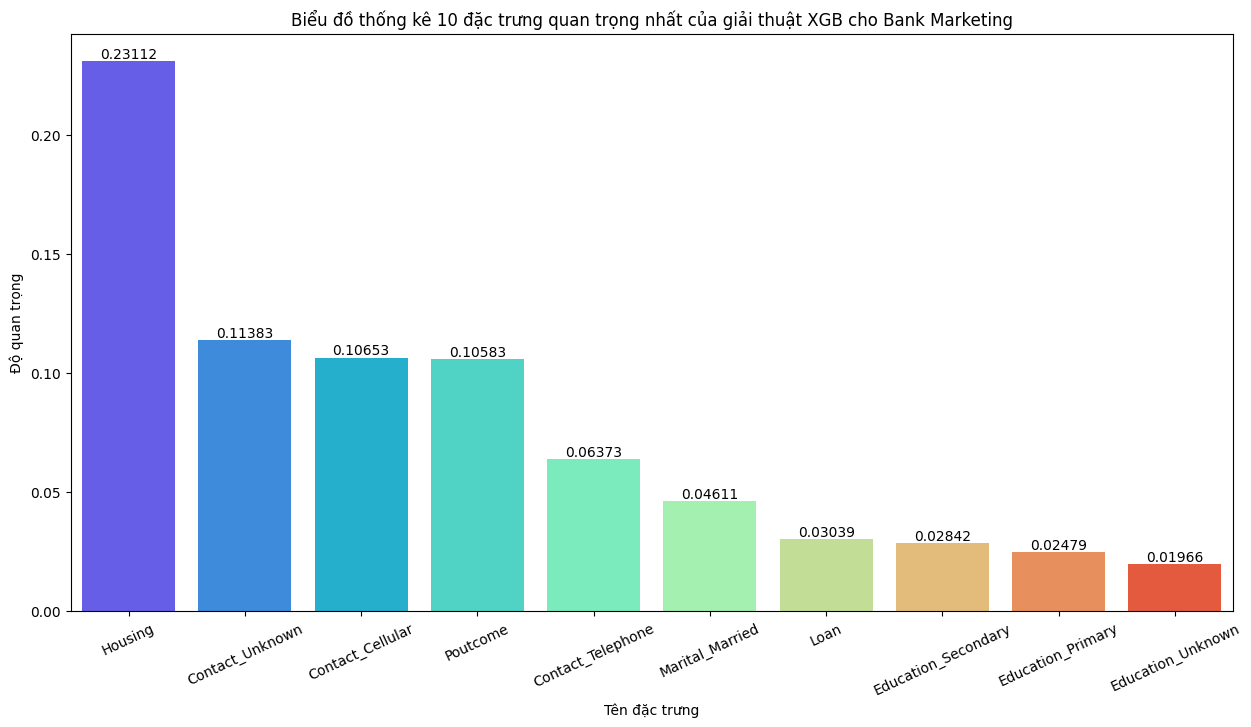

In [12]:
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
for Name, Model in Best_Models.items():
    Model.fit(X_Train, Y_Train)
    plt.figure(figsize=(15,7.5))
    plt.title(f'Biểu đồ thống kê 10 đặc trưng quan trọng nhất của giải thuật {Name} cho Bank Marketing')
    Feature_Importance, Feature_List = Model.feature_importances_, X.columns
    Feature_Importance, Feature_List = zip(*sorted(zip(Feature_Importance, Feature_List), reverse=True))
    Feature_Importance = Feature_Importance[:10]
    Feature_List = Feature_List[:10]           
    sns.barplot(x=Feature_List, y=Feature_Importance, palette='rainbow', hue=Feature_List, legend=False)
    Axes = plt.gca()
    for Each in Axes.patches:
        Percentage = f"{Each.get_height():.5f}"
        x, y = Each.get_x() + Each.get_width()/2, Each.get_height()
        Axes.annotate(Percentage, (x, y), ha='center', va='bottom')  
    plt.xlabel('Tên đặc trưng')
    plt.xticks(rotation=25)
    plt.ylabel('Độ quan trọng')
    plt.show()

In [13]:
Subdirectory  = 'Model'
Dir = os.path.join(os.getcwd(), Subdirectory)
if not os.path.exists(Dir): os.makedirs(Dir)

X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
for Name, Model in Best_Models.items():
    Model.fit(X_Train, Y_Train)
    Path = os.path.join(Dir, f"{Name}.pkl")
    with open(Path, 'wb') as File:
        pickle.dump(Model, File)